In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import matplotlib as mpl

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, classification_report

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR


from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import plotly.express as px

sys.path.append('utils')
from utils.modelCrafter import ModelCrafter

import joblib

pd.set_option('display.max_columns', None)

mpl.rcParams['figure.figsize'] = [10,5]
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False


# **Carregando o dataset**

In [29]:
lines = pd.read_csv('../scr/database/line_profiles.csv')

In [30]:
lines.head()

,sigma,gamma,fwhm,wv_mean,wv_std,int_mean,int_std,int_max,curve_type
0,0.761867,0.198820,2.016159,1514.462764,2.829298,0.006820,0.009448,0.029347,0
1,0.765274,NaN,1.802068,11908.112487,2.253791,0.011716,0.016057,0.047444,1
2,NaN,0.134749,0.269499,12363.465112,0.392897,0.108460,0.113260,0.397276,2
3,0.531288,0.784556,2.287472,19843.757262,3.875260,0.002997,0.003916,0.013428,0
4,0.905249,NaN,2.131680,27894.859041,2.666026,0.005136,0.007039,0.020798,1


# **Verificando integridade dos dados**

In [31]:
lines.isna().sum()

sigma         100000
gamma         100000
fwhm               0
wv_mean            0
wv_std             0
int_mean           0
int_std            0
int_max            0
curve_type         0
dtype: int64

In [32]:
lines.duplicated().sum()

0

# Continuação

In [33]:
model_pipeline = Pipeline([('preprocessor',StandardScaler())])

In [34]:
X = lines.drop(['gamma','sigma','fwhm','curve_type'],axis=1)

y = lines['curve_type']

In [35]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y , shuffle= True,random_state = 0)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [36]:
X_train.shape, X_test.shape

((240000, 5), (60000, 5))

In [55]:
model = Pipeline([#('power',PowerTransformer()),
                  ('norm',StandardScaler()), 
                  ('model',XGBClassifier(random_state=42,n_jobs = -1))
                ])

model.fit(X_train,y_train)

Pipeline(steps=[('norm', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [56]:
pred = model.predict(X_test)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     20000
           1       0.96      1.00      0.98     20000
           2       0.97      1.00      0.99     20000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



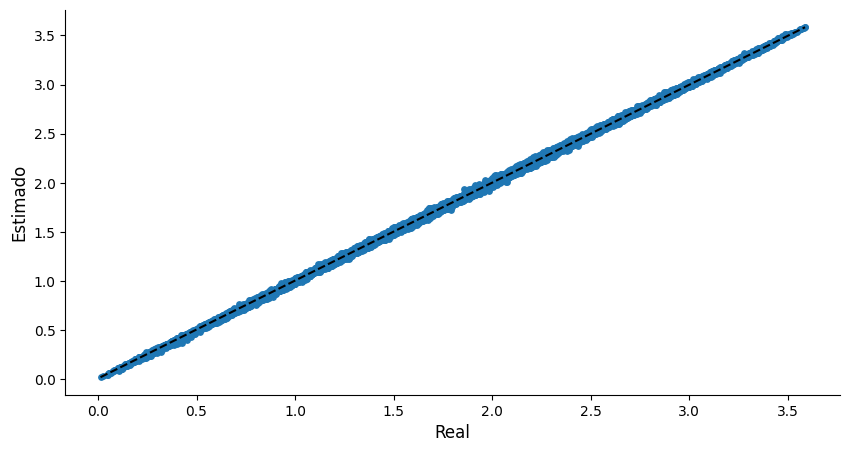

In [44]:
fig,ax = plt.subplots()

ax.plot([y_test.min(),y_test.max()],[pred.min(),pred.max()],'--',color='black',linewidth=1.5)
ax.scatter(x = y_test ,y = pred,s = 15)
ax.set_ylabel('Estimado',size=12)
ax.set_xlabel('Real',size=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('imgs/estimadovsreal.png',dpi=500)

In [57]:
resultados = pd.DataFrame({'real': y_test, 'estimado':pred})

In [63]:
model[-1].feature_importances_

array([0.00149167, 0.5953902 , 0.13625687, 0.17319496, 0.09366623],
      dtype=float32)

In [64]:
importancias = model[-1].feature_importances_
vars = model.feature_names_in_

imp = pd.DataFrame({'feature':vars,'importancia':importancias}).sort_values(by='importancia',ascending=False).reset_index(drop=True)
imp

,feature,importancia
0,wv_std,0.595390
1,int_std,0.173195
2,int_mean,0.136257
3,int_max,0.093666
4,wv_mean,0.001492


Text(0, 0.5, 'Feature')

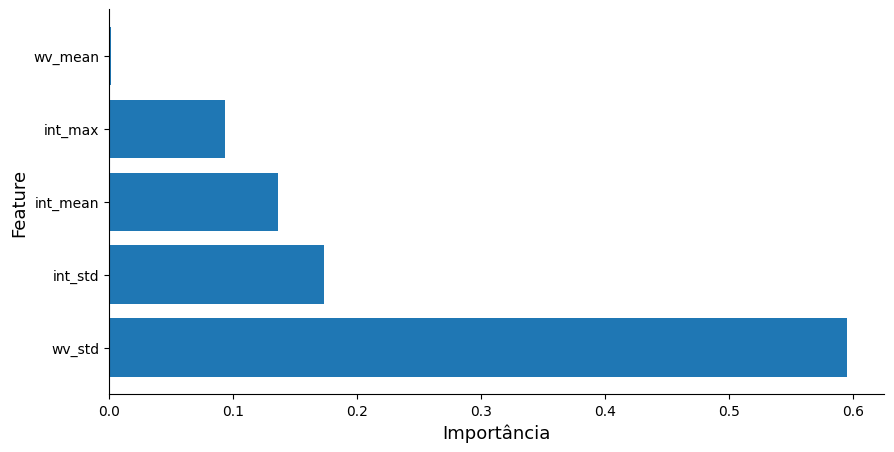

In [65]:
plt.barh(y= imp['feature'],width=imp['importancia'])
plt.xlabel('Importância',size=13)
plt.ylabel('Feature',size=13)

#plt.savefig('imgs/importancia.png',dpi=500)

In [66]:
joblib.dump(model,'model.pkl')

['model.pkl']